# Hands-on 01: Caracterização do desvanecimento de pequena escala

## Entrega 01: Análise de uma medição real (caracterização de canais banda estreita)

### Gráficos dos efeitos do canal:

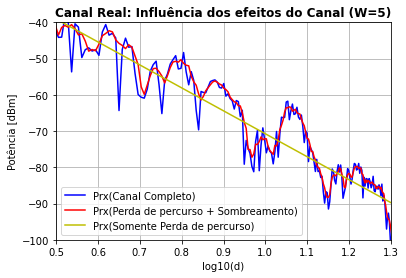

In [1]:
# -*- coding: utf-8 -*-
# Entrega 1: Plotar as curvas de potência recebida do sinal real
# Author: Lucas Ismael Campos Medeiros
# Requisitos: pip install "fitter=1.4"

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.io
import math

# Carregando o canal real
loadmed = scipy.io.loadmat('Prx_Real_2021_1', squeeze_me=True)
vtPrxdBm = loadmed['dPrx']
vtDist = loadmed['dPath']

# Tamanho da janela
dW = 5

# Transforma potência em mWatts
vtPtrxmW = 10**(vtPrxdBm/10)
nSamples = len(vtPtrxmW)

# Vetores para canal estimado
vtDesLarga = [];
vtDesPequeEst = [];

# Cálculo do desvanecimento lento e rápido
dMeiaJanela = int(np.round((dW-1)/2))
ij = 0 
for ik in range(dMeiaJanela,nSamples-dMeiaJanela):
    # Desvanecimento de larga escala: perda de percurso + sombreamento [dB]
    vtDesLarga.append(10*np.log10(np.mean(vtPtrxmW[ik-dMeiaJanela:ik+dMeiaJanela])))
    # Desvanecimento de pequena escala
    vtDesPequeEst.append(vtPrxdBm[ik]-vtDesLarga[ij])
    ij = ij+1

# Cálculo da envoltória normalizada (para efeitos de cálculo do fading)
vtDesLarga = np.asarray(vtDesLarga)
vtDesPequeEst = np.asarray(vtDesPequeEst)
indexes = np.arange(dMeiaJanela,nSamples-dMeiaJanela)
vtPtrxmWNew = 10**(vtPrxdBm[indexes]/10)
desLarga_Lin = (10**(vtDesLarga[0:len(indexes)]/10))
envNormal = np.sqrt(vtPtrxmWNew)/np.sqrt(desLarga_Lin)

# Ajuste no tamanho dos vetores devido a filtragem
vtDistEst = vtDist[dMeiaJanela:nSamples-dMeiaJanela]
vtPrxdBm = vtPrxdBm[dMeiaJanela:nSamples-dMeiaJanela]

# Cálculo da reta de perda de percurso
vtDistLog = np.log10(vtDist)
vtDistLogEst = np.log10(vtDistEst)

# Cálculo dos coeficientes da reta que melhor se caracteriza o PathLoss
dCoefReta = np.polyfit(vtDistLogEst.flatten(), vtPrxdBm,1)
# Expoente de perda de percurso estimado
dNEst = -dCoefReta[0]/10
# Perda de percurso estimada para os pontos de medição
vtPathLossEst = np.polyval(dCoefReta, vtDistLogEst)
# Sombreamento
vtShadCorrEst = vtDesLarga - vtPathLossEst
# Calcula a variância do sombreamento estimado
stdShad = np.std(vtShadCorrEst)
meanShad = np.mean(vtShadCorrEst)

vtPathLossEst = -vtPathLossEst

# Full signal
plt.plot(vtDistLogEst, vtPrxdBm, 'b-', label='Prx(Canal Completo)')
# PL + SW
vtwoFading = vtPrxdBm-vtDesPequeEst
plt.plot(vtDistLogEst, vtwoFading, 'r-', label='Prx(Perda de percurso + Sombreamento)')
# PL
vtwoFadingShad = vtPrxdBm-vtDesPequeEst-vtShadCorrEst
plt.plot(vtDistLogEst,vtwoFadingShad, 'y-', label='Prx(Somente Perda de percurso)')
plt.xlabel('log10(d)')
plt.ylabel('Potência [dBm]')
plt.title('Canal Real: Influência dos efeitos do Canal (W=5)', fontweight='bold')
plt.xlim([0.5,1.3])
plt.ylim([-100,-40])
plt.legend()
plt.grid()
plt.show()

### Cálculo de estimativas

In [7]:
# -*- coding: utf-8 -*-
# Entrega 2: Fazer estimativas para diferentes janelas (2, 5, 10) e mostrar qual é a melhor distribuição
# Author: Lucas Ismael Campos Medeiros
# Requisitos: pip install "fitter=1.4"

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.io
import math
import seaborn as sns
import pandas as pd
from fitter import Fitter, get_common_distributions, get_distributions

def calculaestimativa(dW, vtPrxdBm, vtDist):
    # Transforma potência em mWatts
    vtPtrxmW = 10**(vtPrxdBm/10)
    nSamples = len(vtPtrxmW)

    # Vetores para canal estimado
    vtDesLarga = [];
    vtDesPequeEst = [];

    # Cálculo do desvanecimento lento e rápido
    dMeiaJanela = int(np.ceil((dW-1)/2))
    ij = 0
    for ik in range(dMeiaJanela,nSamples-dMeiaJanela):
        # Desvanecimento de larga escala: perda de percurso + sombreamento [dB]
        vtDesLarga.append(10*np.log10(np.mean(vtPtrxmW[ik-dMeiaJanela:ik+dMeiaJanela])))
        # Desvanecimento de pequena escala
        vtDesPequeEst.append(vtPrxdBm[ik]-vtDesLarga[ij])
        ij = ij+1

    # Cálculo da envoltória normalizada (para efeitos de cálculo do fading)
    vtDesLarga = np.asarray(vtDesLarga)
    vtDesPequeEst = np.asarray(vtDesPequeEst)
    indexes = np.arange(dMeiaJanela,nSamples-dMeiaJanela)
    vtPtrxmWNew = 10**(vtPrxdBm[indexes]/10)
    desLarga_Lin = (10**(vtDesLarga[0:len(indexes)]/10))
    envNormal = np.sqrt(vtPtrxmWNew)/np.sqrt(desLarga_Lin)

    # Ajuste no tamanho dos vetores devido a filtragem
    vtDistEst = vtDist[dMeiaJanela:nSamples-dMeiaJanela]
    vtPrxdBm = vtPrxdBm[dMeiaJanela:nSamples-dMeiaJanela]

    # Cálculo da reta de perda de percurso
    vtDistLog = np.log10(vtDist)
    vtDistLogEst = np.log10(vtDistEst)

    # Cálculo dos coeficientes da reta que melhor se caracteriza o PathLoss
    dCoefReta = np.polyfit(vtDistLogEst.flatten(), vtPrxdBm,1)
    # Expoente de perda de percurso estimado
    dNEst = -dCoefReta[0]/10
    # Perda de percurso estimada para os pontos de medição
    vtPathLossEst = np.polyval(dCoefReta, vtDistLogEst)
    # Sombreamento
    vtShadCorrEst = vtDesLarga - vtPathLossEst
    # Calcula a variância do sombreamento estimado
    stdShad = np.std(vtShadCorrEst)
    meanShad = np.mean(vtShadCorrEst)
    
    print("Janela = " + str(dW))
    print("Std-Shad = " + str(stdShad))
    print("Mean-Shad = " + str(meanShad))
    print("n = " + str(dNEst))
    
    f = Fitter(envNormal)
    #f.distributions = get_common_distributions() + ['nakagami'] + ['rice']
    f.distributions = ['norm', 'expon', 'gamma', 'logistic', 'cauchy', 'uniform', 'genextreme', 'rayleigh', 'beta', 'nakagami', 'rice', 'geninvgauss', 'invgauss', 'genpareto', 'loggamma', 'loglaplace', 'laplace', 'lognorm', 'loguniform', 'weibull_max', 'weibull_min']
    f.fit(progress=False)
    return f

# Carregando o canal real
loadmed = scipy.io.loadmat('Prx_Real_2021_1', squeeze_me=True)
vtPrxdBm = loadmed['dPrx']
vtDist = loadmed['dPath']

Janela = 2
Std-Shad = 5.247721643761028
Mean-Shad = 0.6494160959460306
n = 6.3522208448415025


,sumsquare_error,aic,bic,kl_div
loggamma,33.281054,187.845002,-337.224391,inf
weibull_min,33.483313,184.835247,-336.024726,inf
beta,33.677354,191.390208,-329.592333,inf
logistic,34.178560,224.738550,-337.243823,inf
genextreme,35.563913,190.914211,-324.088447,inf


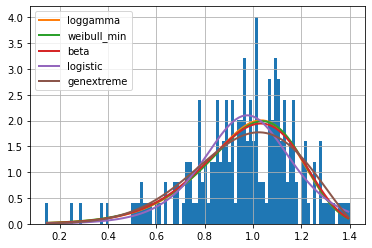

In [8]:
f = calculaestimativa(2, vtPrxdBm, vtDist)
#results = f.df_errors
#print(results.sort_values(by=['sumsquare_error']))
f.summary(Nbest=5, plot=True, clf=False)

Janela = 5
Std-Shad = 4.725437654307958
Mean-Shad = 1.025517275715863
n = 6.335718519624116


,sumsquare_error,aic,bic,kl_div
loggamma,18.185926,200.837426,-450.149118,inf
weibull_min,18.364926,198.784358,-448.229367,inf
beta,18.693662,195.536995,-439.473848,inf
logistic,18.998023,204.067628,-446.864597,inf
norm,20.681148,200.681378,-430.226623,inf


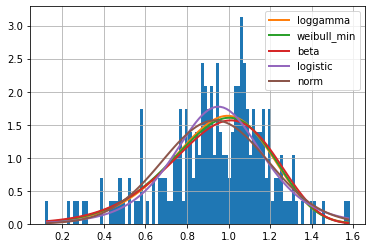

In [9]:
f = calculaestimativa(5, vtPrxdBm, vtDist)
#results = f.df_errors
#print(results.sort_values(by=['sumsquare_error']))
f.summary(Nbest=5, plot=True, clf=False)

Janela = 10
Std-Shad = 4.051223840424837
Mean-Shad = 1.4982785566178294
n = 6.306508508795705


,sumsquare_error,aic,bic,kl_div
logistic,19.097081,174.492338,-426.028784,inf
loggamma,19.468109,169.349004,-417.125744,inf
norm,19.572680,167.983118,-421.354931,inf
nakagami,19.578953,169.886958,-416.047021,inf
lognorm,19.598670,170.472637,-415.855781,inf


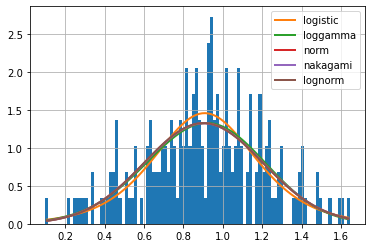

In [10]:
f = calculaestimativa(10, vtPrxdBm, vtDist)
#results = f.df_errors
#print(results.sort_values(by=['sumsquare_error']))
f.summary(Nbest=5, plot=True, clf=False)